In [150]:
# read the hotel reservation file
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import umap
from scipy import stats
import plotly.express as px
from sklearn.manifold import TSNE
hotel = pd.read_csv('Hotel Reservations.csv')

In [151]:
categorical_columns = [
    "type_of_meal_plan",
    "required_car_parking_space",
    "room_type_reserved",
    "market_segment_type",
    "repeated_guest",
    "booking_status"
]

hotel = hotel.drop(['Booking_ID'], axis=1)    # Booking_ID is useless

numerical_columns = hotel.columns.difference(categorical_columns)


# Preprocessing
**Delete rows that normally would not make sense, such as :**
- reservation without any adults

In [145]:
def encodage(data):
    for column, content in data.items():        # object -> category 
        if (pd.api.types.is_object_dtype(content)):
            data[column] = content.astype('category').cat.as_ordered()
            
    for column, content in data.items():       # category -> integer (+1)
        if pd.api.types.is_categorical_dtype(content):
            data[column] =  pd.Categorical(content).codes + 1

In [67]:

# check for null number 
print(hotel.isnull().sum())
print("Empty room reservations : ", len(hotel[(hotel["no_of_adults"]==0) & (hotel["no_of_children"]>0)]))    # check for abnormal values

hotel.drop(hotel[(hotel["no_of_adults"]==0) & (hotel["no_of_children"]>0)].index,axis=0, inplace=True)    # Drop person number = 0


no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64
Empty room reservations :  139


# Tendinta centrala a variabilelor numerice

In [6]:
hotel[numerical_columns].describe()    # check for outliers dsa

,arrival_date,arrival_month,arrival_year,avg_price_per_room,lead_time,no_of_adults,no_of_children,no_of_previous_bookings_not_canceled,no_of_previous_cancellations,no_of_special_requests,no_of_week_nights,no_of_weekend_nights
count,36136.000000,36136.000000,36136.000000,36136.000000,36136.000000,36136.000000,36136.000000,36136.000000,36136.000000,36136.000000,36136.000000,36136.000000
mean,15.589883,7.424424,2017.820013,103.507653,85.182090,1.852059,0.097880,0.154002,0.023439,0.618414,2.203592,0.810272
std,8.740466,3.068408,0.384182,35.061640,85.951426,0.506908,0.385097,1.757515,0.369036,0.785564,1.410836,0.870519
min,1.000000,1.000000,2017.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,5.000000,2018.000000,80.375000,17.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,16.000000,8.000000,2018.000000,99.455000,57.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
75%,23.000000,10.000000,2018.000000,120.120000,126.000000,2.000000,0.000000,0.000000,0.000000,1.000000,3.000000,2.000000
max,31.000000,12.000000,2018.000000,540.000000,443.000000,4.000000,10.000000,58.000000,13.000000,5.000000,17.000000,7.000000


# Imprastierea

### Skeweness
- Skewness = 0 (normally distributed)
- Skewness > 0 (positively skewed. Longer tail on the right side of the distribution)
- Skewness < 0 (negatively skewed. Longer tail on the left side of the distribution)

### Kurtosis
- Excess Kurtosis = Kurtosis - 3 (0 for normal distribution)
- Leptokurtic: Kurtosis > 0 (more outliers than normal distribution)
- Platykurtic: Kurtosis < 0 (less outliers than normal distribution)

In [7]:
# imprastierea variabilelor numerice
def dispersion(col):
    return [col.max() - col.min(), col.var(), col.std(), col.skew(), col.kurt()]

dispersion_table = pd.DataFrame(columns=['Range', 'Variance', 'Standard Deviation', 'Skewness', 'Kurtosis'])
for column in numerical_columns:
    dispersion_table.loc[column] = dispersion(hotel[column])

dispersion_table


,Range,Variance,Standard Deviation,Skewness,Kurtosis
arrival_date,30.0,76.395740,8.740466,0.029624,-1.156948
arrival_month,11.0,9.415127,3.068408,-0.348185,-0.933292
arrival_year,1.0,0.147596,0.384182,-1.666040,0.775731
avg_price_per_room,540.0,1229.318596,35.061640,0.676135,3.158032
lead_time,443.0,7387.647595,85.951426,1.294455,1.184577
no_of_adults,3.0,0.256956,0.506908,-0.215035,0.534689
no_of_children,10.0,0.148299,0.385097,4.965036,42.747885
no_of_previous_bookings_not_canceled,58.0,3.088861,1.757515,19.213120,455.617403
no_of_previous_cancellations,13.0,0.136188,0.369036,25.151407,729.915012
no_of_special_requests,5.0,0.617111,0.785564,1.145437,0.877823


# Frecvente ale atributelor categoriale

In [8]:
freq_table = pd.DataFrame(columns=['Value','Frequency', 'Percentage'])
for column in categorical_columns:
    freq_table.loc[column] = [hotel[column].value_counts().index[0], hotel[column].value_counts()[0], hotel[column].value_counts()[0] / len(hotel[column]) * 100]

freq_table

,Value,Frequency,Percentage
type_of_meal_plan,Meal Plan 1,27698,76.649325
required_car_parking_space,0.0,35013.0,96.892296
room_type_reserved,Room_Type 1,28127,77.836507
market_segment_type,Online,23080,63.869825
repeated_guest,0.0,35206.0,97.426389
booking_status,Not_Canceled,24295,67.232123


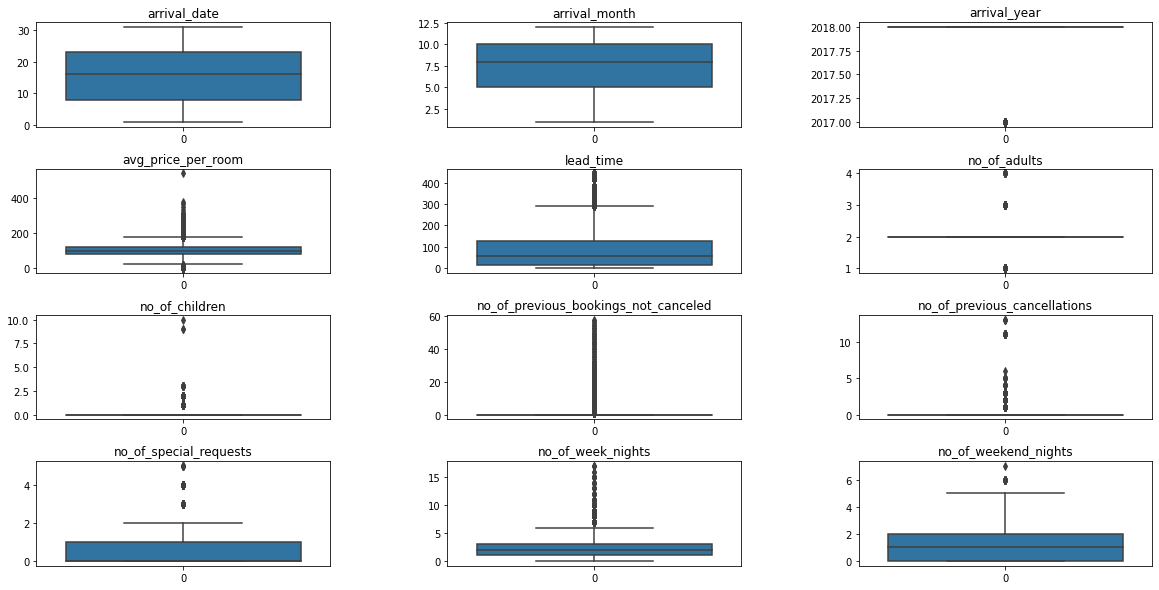

In [13]:
# grafice (box plot)
def box_plot(col):
    plt.boxplot(col)
    plt.title(col.name)
    plt.show()

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, col in enumerate(numerical_columns):
    fig.add_subplot(4, 3, i+1)
    sns.boxplot(hotel[col])  
    plt.title(col)


# Histograme pentru atribute numerice

<Figure size 720x720 with 0 Axes>

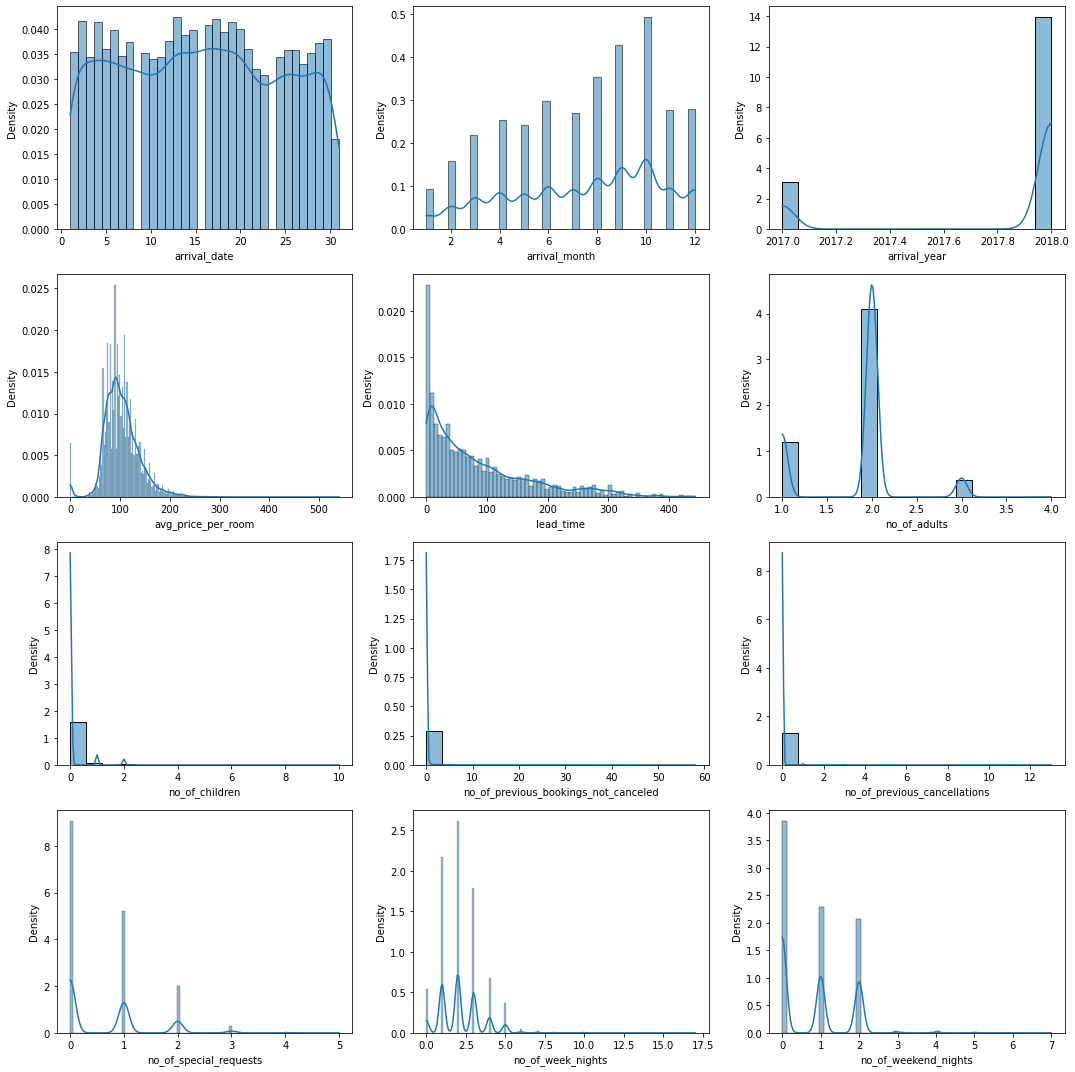

In [14]:
figure = plt.figure()
figure.set_size_inches(10, 10)
figure, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
figure.subplots_adjust(hspace = 1, wspace = 0.4)

for i, ax in enumerate(axes.flat, start=1):
    sns.histplot(hotel[numerical_columns[i-1]], ax=ax, kde=True, stat='density')

plt.tight_layout()
plt.show()



# Histograme atribute categoriale

<Figure size 720x720 with 0 Axes>

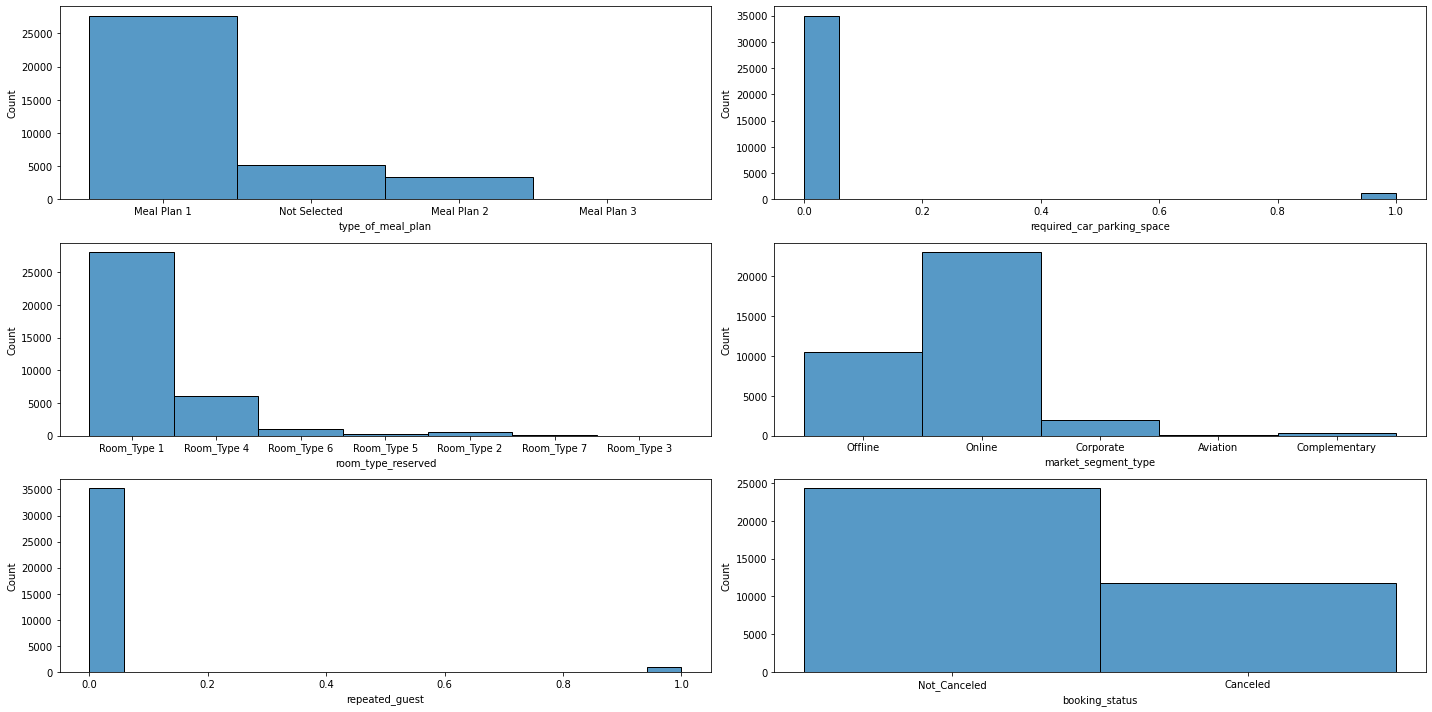

In [15]:
figure = plt.figure()
figure.set_size_inches(10, 10)
figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
figure.subplots_adjust(hspace = 1, wspace = 0.4)

for i, ax in enumerate(axes.flat, start=1):
    sns.histplot(hotel[categorical_columns[i-1]], ax=ax)

plt.tight_layout()
plt.show()


# Analiza bivariata

## Calculul corelatiei dintre variabile numerice

In [16]:
corr_matrix = hotel[numerical_columns].corr()
corr_matrix

,arrival_date,arrival_month,arrival_year,avg_price_per_room,lead_time,no_of_adults,no_of_children,no_of_previous_bookings_not_canceled,no_of_previous_cancellations,no_of_special_requests,no_of_week_nights,no_of_weekend_nights
arrival_date,1.000000,-0.043546,0.018952,0.018237,0.005717,0.030028,0.022648,-0.001430,-0.012515,0.017830,-0.009551,0.027170
arrival_month,-0.043546,1.000000,-0.339944,0.053747,0.136309,0.021528,-0.002276,-0.010766,-0.038724,0.110130,0.037266,-0.010103
arrival_year,0.018952,-0.339944,1.000000,0.179146,0.143256,0.082675,0.043137,0.026544,0.003991,0.052832,0.032583,0.055111
avg_price_per_room,0.018237,0.053747,0.179146,1.000000,-0.062617,0.296445,0.366890,-0.114204,-0.063665,0.185859,0.023530,-0.005090
lead_time,0.005717,0.136309,0.143256,-0.062617,1.000000,0.102057,-0.052184,-0.078218,-0.045763,-0.102255,0.149263,0.046006
no_of_adults,0.030028,0.021528,0.082675,0.296445,0.102057,1.000000,0.048947,-0.123404,-0.049513,0.200499,0.110338,0.108038
no_of_children,0.022648,-0.002276,0.043137,0.366890,-0.052184,0.048947,1.000000,-0.020514,-0.015949,0.122734,0.023171,0.028651
no_of_previous_bookings_not_canceled,-0.001430,-0.010766,0.026544,-0.114204,-0.078218,-0.123404,-0.020514,1.000000,0.468136,0.027592,-0.049398,-0.026321
no_of_previous_cancellations,-0.012515,-0.038724,0.003991,-0.063665,-0.045763,-0.049513,-0.015949,0.468136,1.000000,-0.003226,-0.030108,-0.020700
no_of_special_requests,0.017830,0.110130,0.052832,0.185859,-0.102255,0.200499,0.122734,0.027592,-0.003226,1.000000,0.045928,0.060008


<AxesSubplot:>

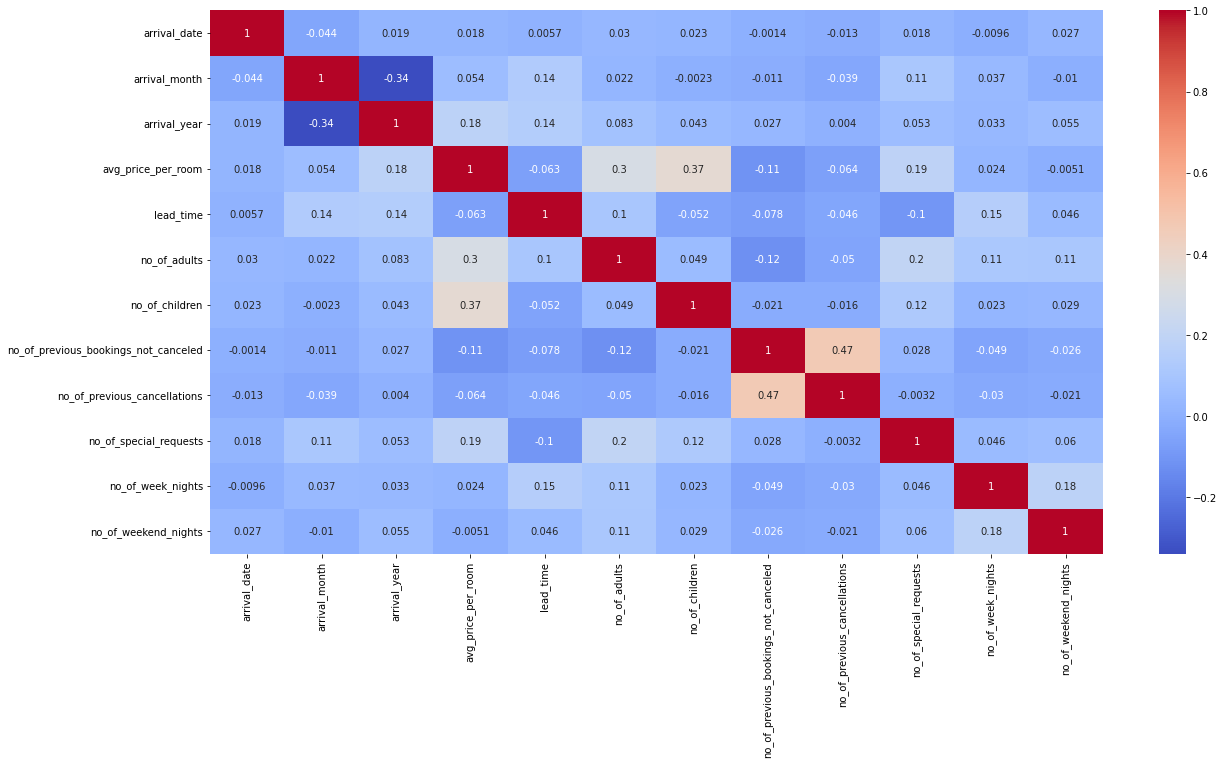

In [17]:
# make the graphic wider
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

* Am observat o corelatie intre numarul de adulti si pretul mediu al camerei, intre numarul de copii si pretul mediu al camerei (odata cu cresterea numarului de persoane creste si pretul camerei)

## Teste de independenta


### Testul Chi Square pentru atribute categoriale
Like all hypothesis tests, the chi-square test of independence evaluates a null and alternative hypothesis. The hypotheses are two competing answers to the question “Are variable 1 and variable 2 related?”

    Null hypothesis (H0): Variable 1 and variable 2 are not related in the population; The proportions of variable 1 are the same for different values of variable 2.
    Alternative hypothesis (Ha): Variable 1 and  variable 2 are related in the population; The proportions of variable 1 are not the same for different values of  variable 2.


<Figure size 500x500 with 0 Axes>

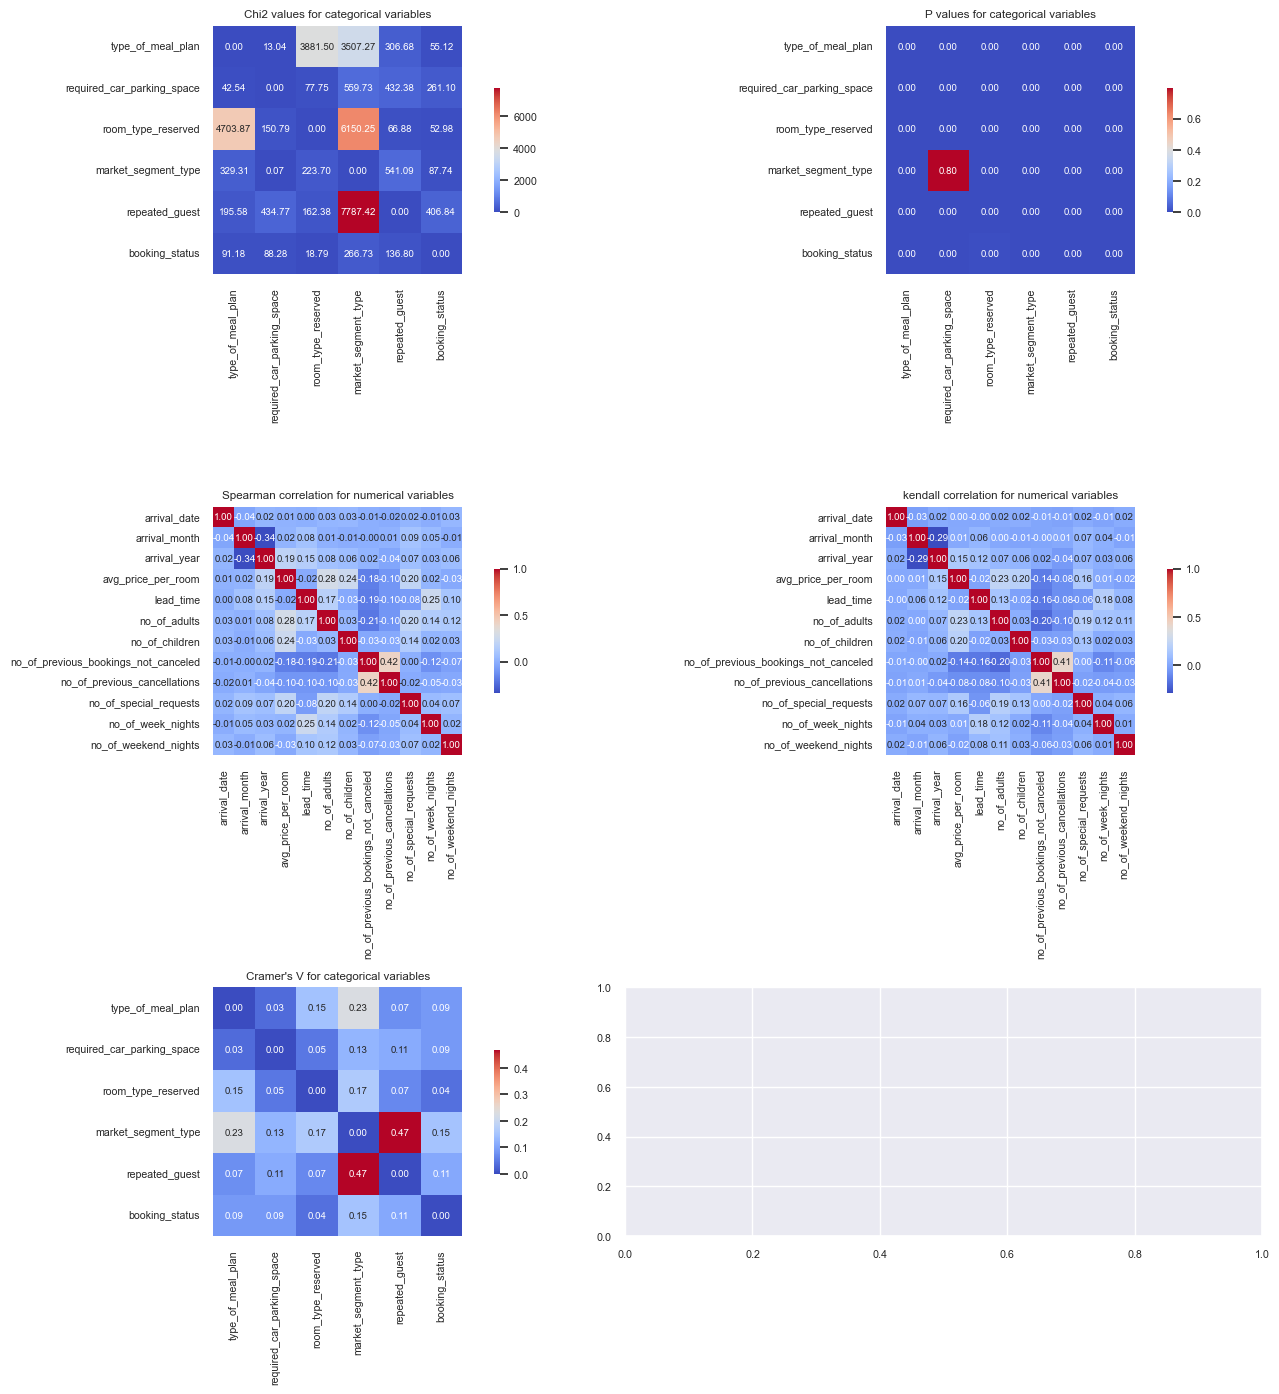

In [38]:
from sklearn.feature_selection import chi2
import numpy as np

resultant = pd.DataFrame(data=[(0 for i in range(len(categorical_columns))) for i in range(len(categorical_columns))], 
                         columns=list(categorical_columns))
resultant.set_index(pd.Index(list(categorical_columns)), inplace = True)

resultant_chi = pd.DataFrame(data=[(0 for i in range(len(categorical_columns))) for i in range(len(categorical_columns))], 
                         columns=list(categorical_columns))
resultant_chi.set_index(pd.Index(list(categorical_columns)), inplace = True)
 

for column in categorical_columns:
    #convert the categorical variable into dummy/indicator variables
    hotel[column] = pd.Categorical(hotel[column]).codes

for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 != col2:
            chi2_val, p_val = chi2(np.array(hotel[col1]).reshape(-1, 1), np.array(hotel[col2]).reshape(-1, 1))
            resultant.loc[col1, col2] = p_val
            resultant_chi.loc[col1, col2] = chi2_val

#Spearman correlation
spearman_corr = hotel[numerical_columns].corr(method='spearman')

#Kendall correlation
kendall_corr = hotel[numerical_columns].corr(method='kendall')

#Cramer's V
cramer_v = pd.DataFrame(data=[(0 for i in range(len(categorical_columns))) for i in range(len(categorical_columns))],
                        columns=list(categorical_columns))
cramer_v.set_index(pd.Index(list(categorical_columns)), inplace = True)

for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 != col2:
            contingency_table = pd.crosstab(hotel[col1], hotel[col2])
            cramer = stats.contingency.association(contingency_table, method="cramer")
            cramer_v.loc[col1, col2] = cramer
            cramer_v.loc[col2, col1] = cramer

titles= ['Chi2 values for categorical variables','P values for categorical variables', 'Spearman correlation for numerical variables',
         'kendall correlation for numerical variables', 'Cramer\'s V for categorical variables']
values = [resultant_chi, resultant, spearman_corr, kendall_corr, cramer_v]

figure = plt.figure()
figure.set_size_inches(5, 5)
figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 14))
figure.subplots_adjust(hspace = 1, wspace = 0.4)
sns.set(font_scale=.7)

for i, ax in enumerate(axes.flat, start=1):
    ax.set_title(titles[i-1])
    sns.heatmap(values[i-1], annot=True, cmap='coolwarm', ax=ax, square=True, cbar_kws={'shrink': .5}, annot_kws={'size': 7}, fmt='.2f')
    if i == len(titles):
        break

plt.tight_layout()
plt.show()


## Teste ce compara mai multe populatii

### Testul Anova

KeyboardInterrupt: 

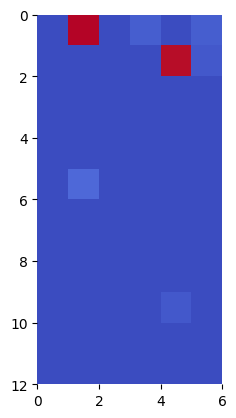

In [78]:
# anova heatmap for numerical variables and categorical variables
anova_df = pd.DataFrame(data=[(0 for i in range(len(categorical_columns))) for i in range(len(numerical_columns))],
                        columns=list(categorical_columns))
anova_df.set_index(pd.Index(list(numerical_columns)), inplace = True)

for col1 in numerical_columns:
    for col2 in categorical_columns:
        groups = hotel.groupby(col2)[col1].apply(list).values
        pvalue = stats.f_oneway(*groups)[1]
        anova_df.loc[col1, col2] = pvalue 

# for col1 in numerical_columns:
#     for col2 in categorical_columns:
#         anova_df.loc[col1, col2] = stats.f_oneway(hotel[col1][hotel[col2] == 0], hotel[col1][hotel[col2] == 1]).pvalue

sns.heatmap(anova_df, annot=True, cmap='coolwarm', square=True, annot_kws={'size': 7}, fmt='.2f')


### Scatterplots

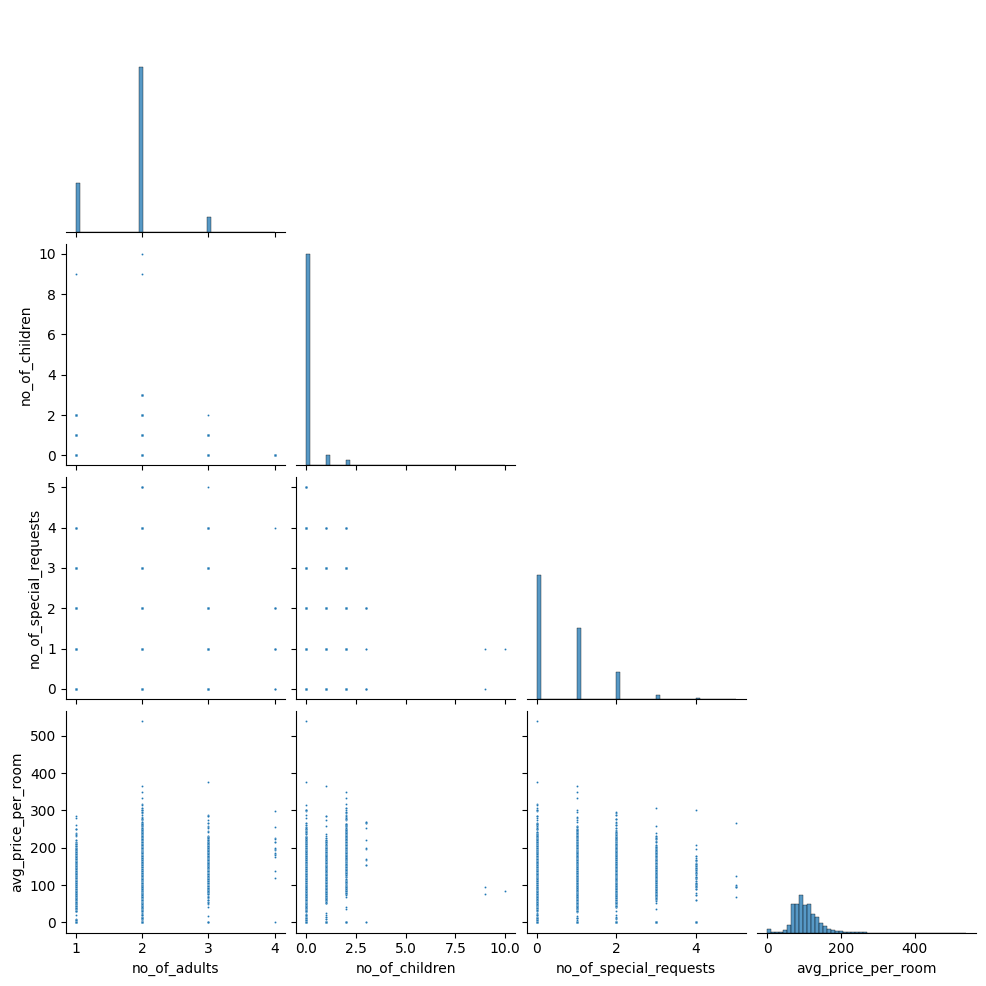

In [81]:
scatter_columns = [
    "no_of_adults",
    "no_of_children",
    "no_of_special_requests",
    "avg_price_per_room",
]
# pd.plotting.scatter_matrix(hotel[scatter_columns], hist_kwds={'bins': 50}, s=25, alpha=.4, figsize=(10, 10))
sns.pairplot(hotel[scatter_columns], diag_kind='hist', corner=True, plot_kws={'s': 2}, diag_kws={'bins': 50})

### 3D Scatterplots

In [83]:
%matplotlib widget

# 3d grafic (atribute numerice)
def scatter_3d_plot(col1, col2, col3, name1, name2, name3):
    # fig = plt.figure()
    # # fig.add_subplot(111, projection='3d')
    # ax = fig.add_subplot(111, projection='3d')
    # ax.scatter(col1, col2, col3)
    # ax.set_xlabel(name1)
    # ax.set_ylabel(name2)
    # ax.set_zlabel(name3)
    # plt.show()
    fig = px.scatter_3d(hotel, x=name1, y=name2, z=name3)
    fig.show()

first_column = hotel["no_of_adults"].copy()
second_column = hotel["no_of_children"].copy()
third_column = hotel["avg_price_per_room"].copy()
first_name = "no_of_adults"
second_name = "no_of_children"
third_name = "avg_price_per_room"

scatter_3d_plot(first_column, second_column, third_column, first_name, second_name, third_name)

### Analiza componentelor principale

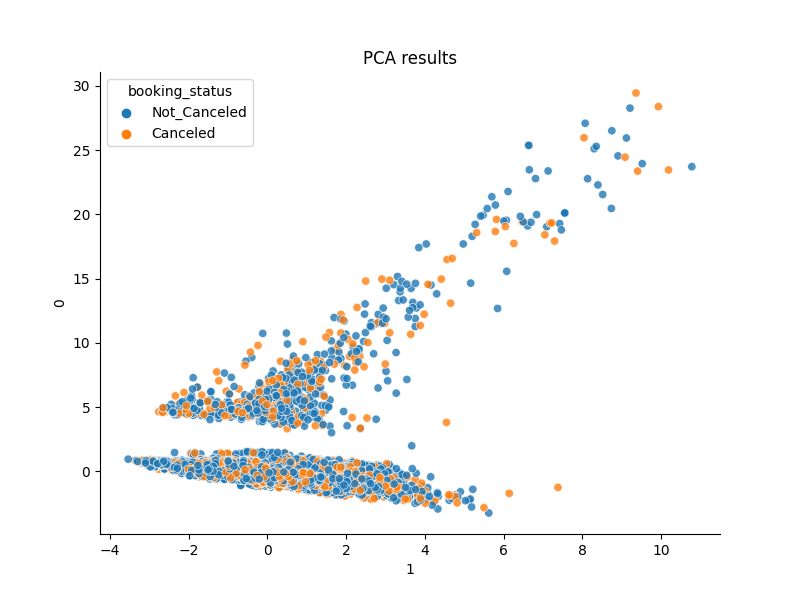

([<matplotlib.axis.XTick at 0x1d581c7e860>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16')])

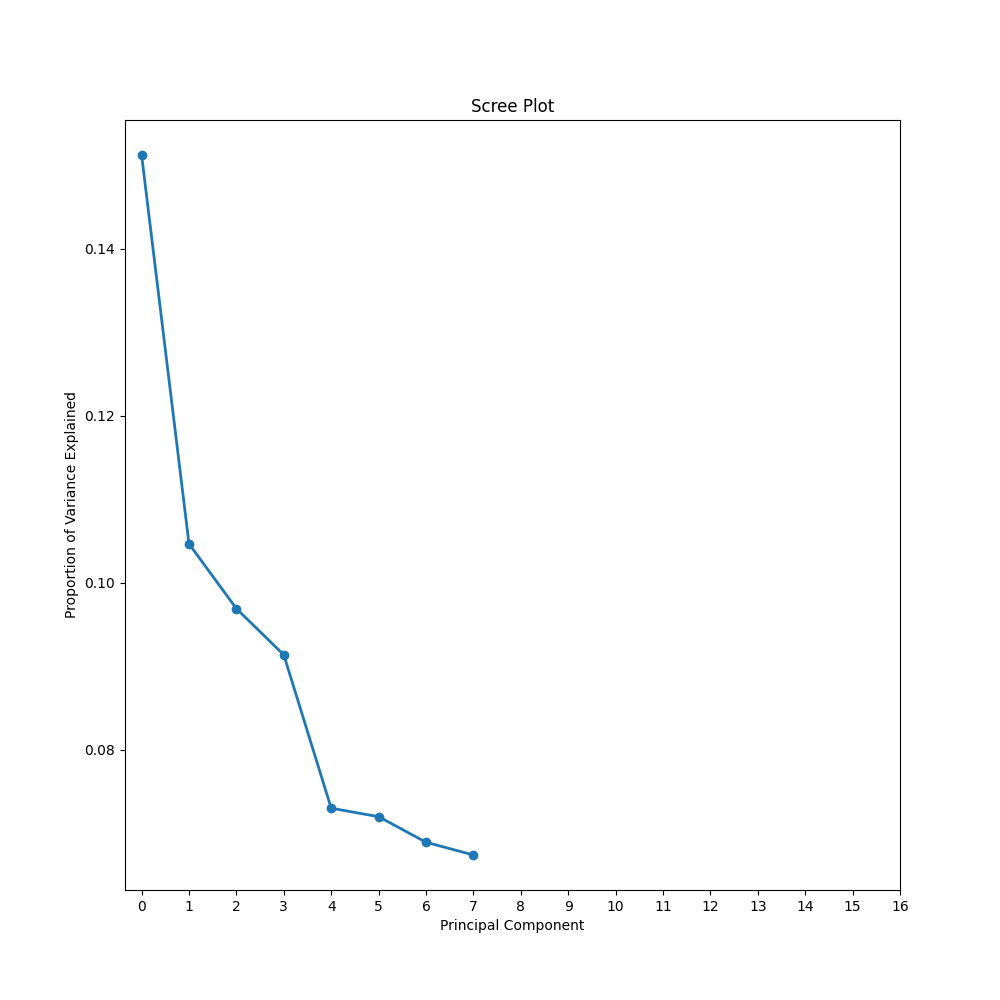

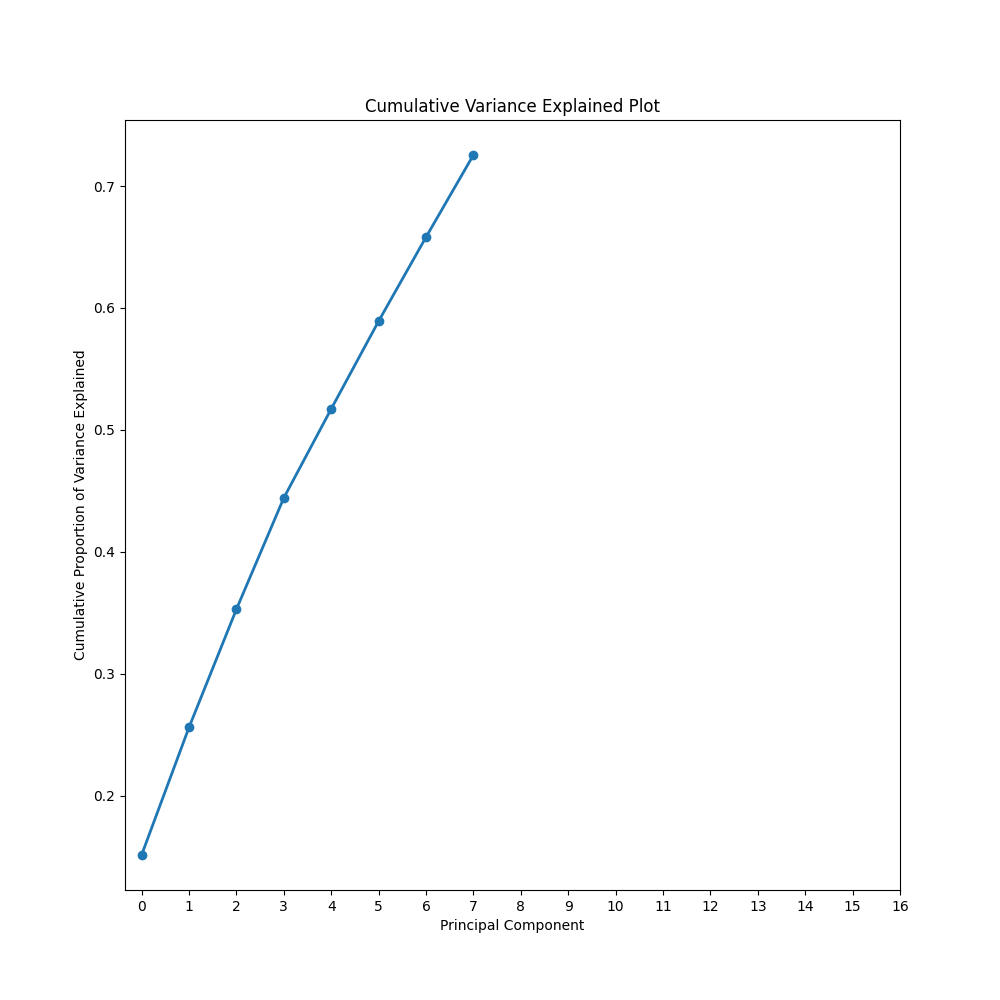

In [143]:
x= hotel.drop("booking_status", axis = 1)
y = hotel["booking_status"]

numcols = x.select_dtypes("int64").columns
catcols = x.select_dtypes("object").columns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

t = ColumnTransformer(transformers =[
    ("onehot", OneHotEncoder(),catcols ),
    ("Scale", StandardScaler(), numcols)
])

train_features =t.fit_transform(x)

from sklearn.decomposition import PCA
PCA = PCA(n_components = 8)

PCA.fit(train_features)

x_pca =PCA.transform(train_features)

pca = pd.DataFrame(x_pca)
pca_y = pca.join(y)

plt.figure(figsize=(8,6))
sns.scatterplot(data = pca_y, x=0, y=1, hue="booking_status", alpha = .8)
sns.despine(top = True, right = True, left = False, bottom = False)
plt.title("PCA results")

plt.show()

plt.figure(figsize=(10, 10))
plt.plot(PCA.explained_variance_ratio_, 'o-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(17))

# cumulative variance explained plot
plt.figure(figsize=(10, 10))
plt.plot(np.cumsum(PCA.explained_variance_ratio_), 'o-', linewidth=2)
plt.title('Cumulative Variance Explained Plot')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.xticks(range(17))

In [144]:
# principal component analysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# standardize the data
scaler = StandardScaler()
dataset = hotel.copy()
for cat_col in categorical_columns:
    if cat_col != 'booking_status':
        dataset[cat_col] = dataset[cat_col].astype('category').cat.codes

dataset.drop(['booking_status'], axis=1, inplace=True)

scaler.fit(dataset)
hotel_scaled = scaler.transform(dataset)

# apply PCA
pca = PCA(n_components=17)
pca.fit(hotel_scaled)

# transform the data
hotel_pca = pca.transform(hotel_scaled)
pca_y = pd.DataFrame(hotel_pca).join(hotel["booking_status"])

loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 
                                                    'PC13', 'PC14', 'PC15', 'PC16', 'PC17'], index=dataset.columns)

plt.figure(figsize=(10, 10))
sns.scatterplot(data = pca_y, x=0, y=1, hue="booking_status", alpha = .8)
sns.despine(top = True, right = True, left = False, bottom = False)
plt.title("PCA results")

plt.show()

plt.figure(figsize=(10, 10))
plt.plot(pca.explained_variance_ratio_, 'o-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(17))

# cumulative variance explained plot
plt.figure(figsize=(10, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o-', linewidth=2)
plt.title('Cumulative Variance Explained Plot')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.xticks(range(17))


ValueError: A given column is not a column of the dataframe

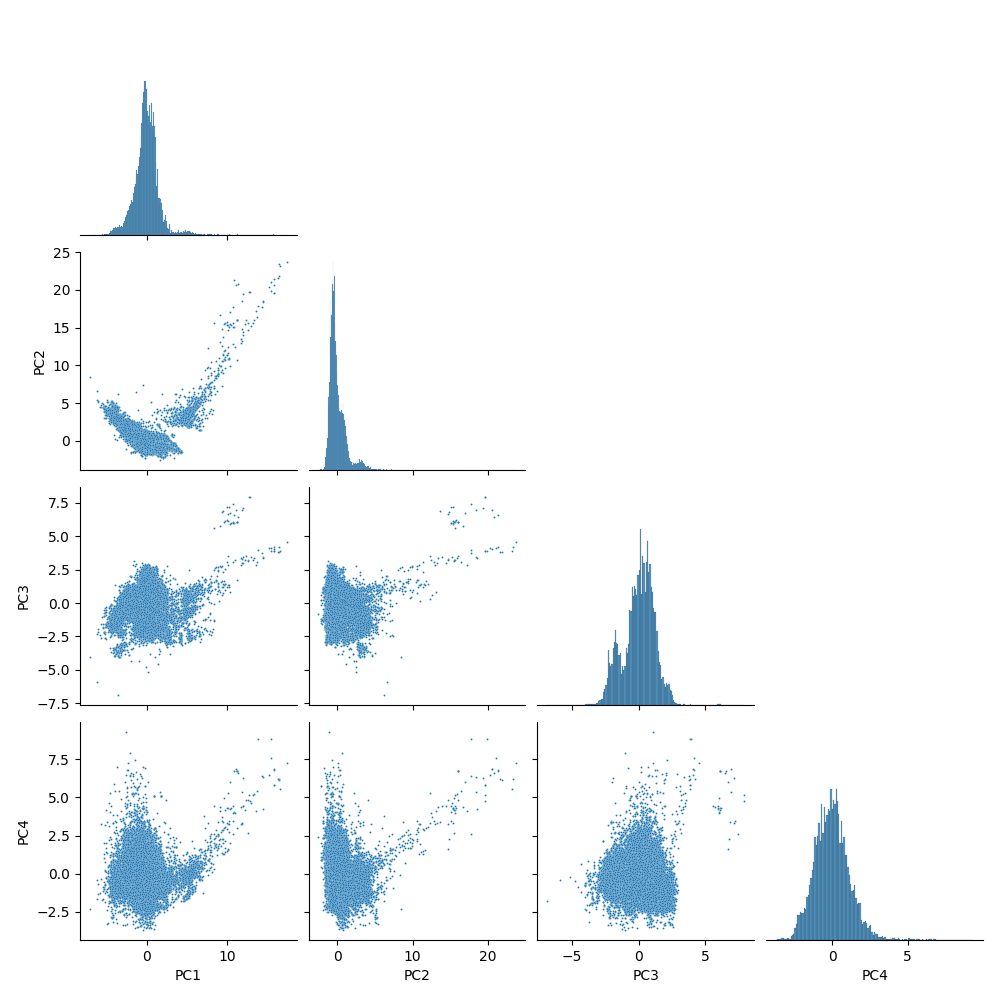

In [108]:
#pairplot for the first 8 principal components
hotel_pca_df = pd.DataFrame(hotel_pca, columns=['PC'+str(i) for i in range(1, 18)])
sns.pairplot(hotel_pca_df.iloc[:, :4], diag_kind='hist', corner=True, plot_kws={'s': 2})

In [109]:
#find the importance of each feature in the first principal component
print(loadings['PC1'].abs().sort_values(ascending=False))
print(loadings['PC2'].abs().sort_values(ascending=False))

avg_price_per_room                      0.415381
market_segment_type                     0.412000
repeated_guest                          0.354322
no_of_adults                            0.348732
room_type_reserved                      0.322369
no_of_previous_bookings_not_canceled    0.295495
no_of_children                          0.246646
no_of_previous_cancellations            0.224480
no_of_special_requests                  0.224282
arrival_year                            0.141628
no_of_week_nights                       0.140791
no_of_weekend_nights                    0.121964
lead_time                               0.040518
arrival_date                            0.034308
arrival_month                           0.013069
type_of_meal_plan                       0.005449
required_car_parking_space              0.003804
Name: PC1, dtype: float64
no_of_previous_bookings_not_canceled    0.448475
repeated_guest                          0.414770
no_of_previous_cancellations            0.3

Non-linear bidimensional mappings

In [25]:
dataset = hotel[numerical_columns]
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=250)
tsne_results = tsne.fit_transform(dataset)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 36275 samples in 0.183s...
[t-SNE] Computed neighbors for 36275 samples in 2.277s...
[t-SNE] Computed conditional probabilities for sample 1000 / 36275
[t-SNE] Computed conditional probabilities for sample 2000 / 36275
[t-SNE] Computed conditional probabilities for sample 3000 / 36275
[t-SNE] Computed conditional probabilities for sample 4000 / 36275
[t-SNE] Computed conditional probabilities for sample 5000 / 36275
[t-SNE] Computed conditional probabilities for sample 6000 / 36275
[t-SNE] Computed conditional probabilities for sample 7000 / 36275
[t-SNE] Computed conditional probabilities for sample 8000 / 36275
[t-SNE] Computed conditional probabilities for sample 9000 / 36275
[t-SNE] Computed conditional probabilities for sample 10000 / 36275
[t-SNE] Computed conditional probabilities for sample 11000 / 36275
[t-SNE] Computed conditional probabilities for sample 12000 / 36275
[t-SNE] Computed conditional probabilities for sa

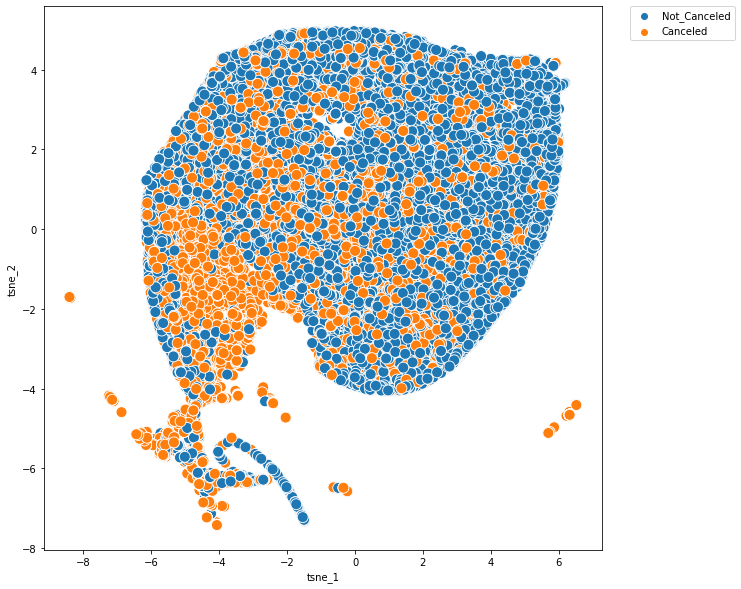

In [51]:
# plot the result of TSNE with the label color coded
tsne_result_df = pd.DataFrame({'tsne_1': tsne_results[:,0], 'tsne_2': tsne_results[:,1], 'label': hotel['booking_status']})
fig, ax = plt.subplots(1)
fig.set_size_inches(10, 10)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
# lim = (tsne_results.min()-5, tsne_results.max()+5)
# ax.set_xlim(lim)
# ax.set_ylim(lim)
# ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)



### uMap

In [24]:
from sklearn.preprocessing import StandardScaler
data = hotel

for cat_col in categorical_columns:
    data[cat_col] = data[cat_col].astype('category').cat.codes

scaled_data = StandardScaler().fit_transform(data)

reducer = umap.UMAP()

embedding = reducer.fit_transform(scaled_data)

d:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Text(0.5, 1.0, 'UMAP projection of the hotel dataset')

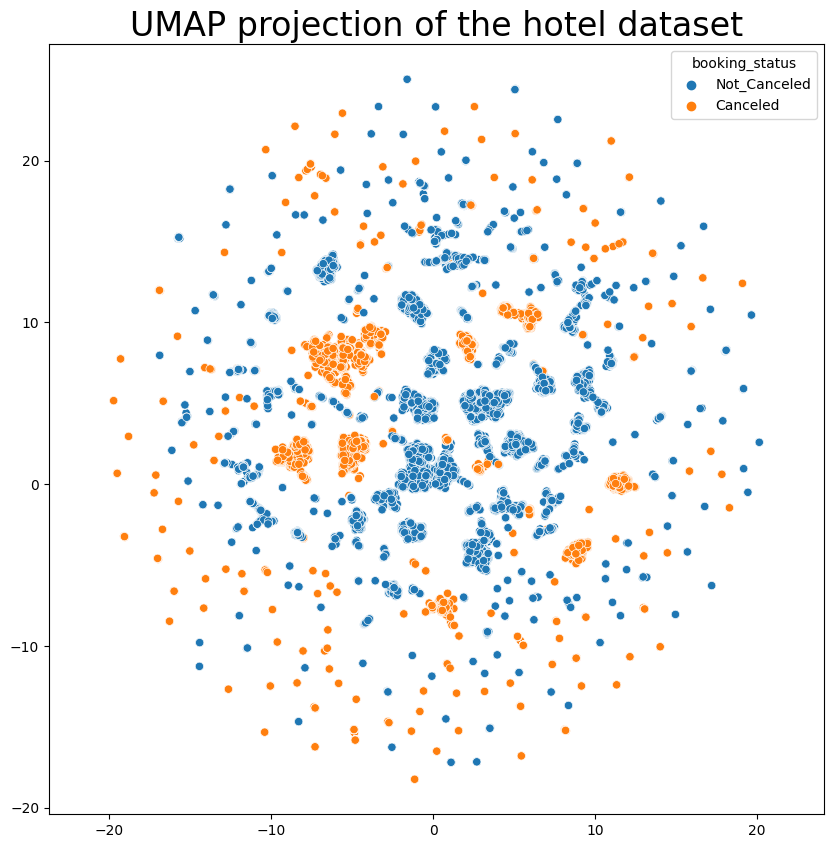

In [37]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=hotel.booking_status)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the hotel dataset', fontsize=24)

### Sammon

In [6]:
from sammon.sammon import sammon

df = hotel[numerical_columns]
# df = df.as_matrix()

y, e = sammon(df, 2, maxiter=1, display=1)

### T-test

In [77]:
temp_df = hotel.copy()

for cat_col in categorical_columns:
    temp_df[cat_col] = temp_df[cat_col].astype('category').cat.codes

t_stat, p_value = stats.ttest_ind(temp_df[hotel.booking_status == 'Canceled'], temp_df[hotel.booking_status == 'Not_Canceled'], equal_var=False)
for i in range(len(p_value)):
    print(hotel.columns[i], p_value[i], t_stat[i])

print(hotel[hotel.booking_status == 'Canceled']['lead_time'].median())
print(hotel[hotel.booking_status == 'Not_Canceled']['lead_time'].median())
print("---------------------")
print(hotel[hotel.booking_status == 'Canceled']['no_of_special_requests'].median())
print(hotel[hotel.booking_status == 'Not_Canceled']['no_of_special_requests'].median())


no_of_adults 1.9345253475709744e-68 17.535449990894485
no_of_children 2.0034501853140845e-10 6.364306623228386
no_of_weekend_nights 1.0093281704434595e-29 11.339848841821798
no_of_week_nights 3.157038245417444e-61 16.565709776138743
type_of_meal_plan 3.788817921395253e-07 5.0807289629243675
required_car_parking_space 4.683163282445571e-92 -20.40816019130208
room_type_reserved 1.3591073688645307e-05 4.351326442396521
lead_time 0.0 80.43905526483107
arrival_year 0.0 39.979169563518624
arrival_month 0.018947559599713164 -2.346696720839616
arrival_date 0.040037683236619305 2.053474703644861
market_segment_type 6.403309326293967e-182 28.957512801871914
repeated_guest 9.261449100647606e-178 -28.63541972000149
no_of_previous_cancellations 2.3066357827498886e-14 -7.635491077530978
no_of_previous_bookings_not_canceled 3.852262564191205e-60 -16.402036037094916
avg_price_per_room 1.0983691249622683e-174 28.396205201360804
no_of_special_requests 0.0 -56.196940514819836
booking_status 0.0 -inf
122.

C:\Users\cezar\AppData\Local\Temp\ipykernel_6800\1998838173.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_value = stats.ttest_ind(temp_df[hotel.booking_status == 'Canceled'], temp_df[hotel.booking_status == 'Not_Canceled'], equal_var=False)


### Stacked histograms

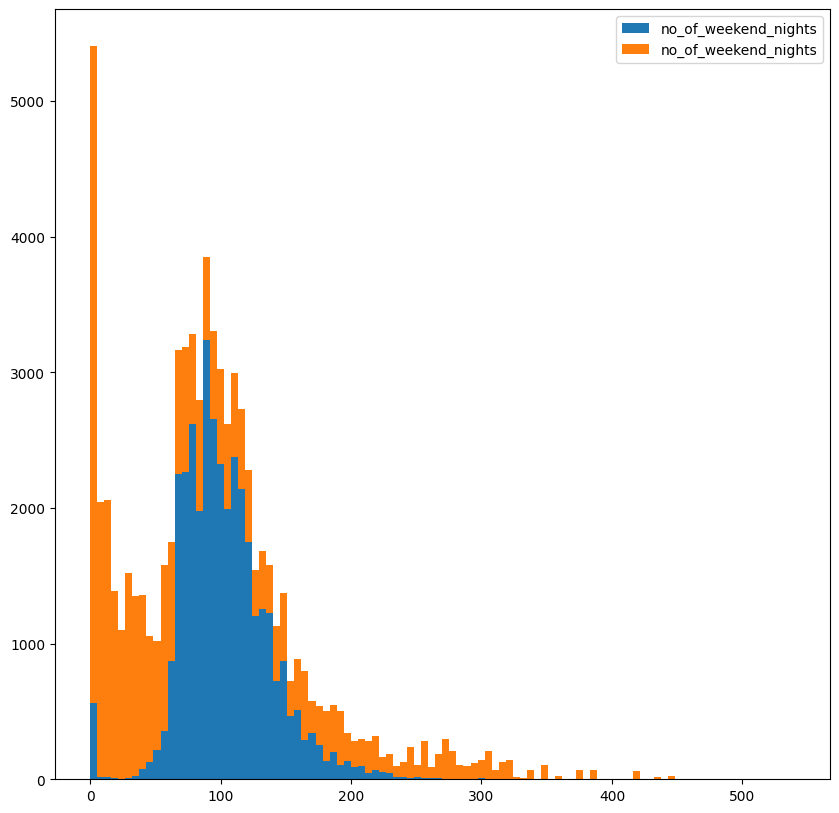

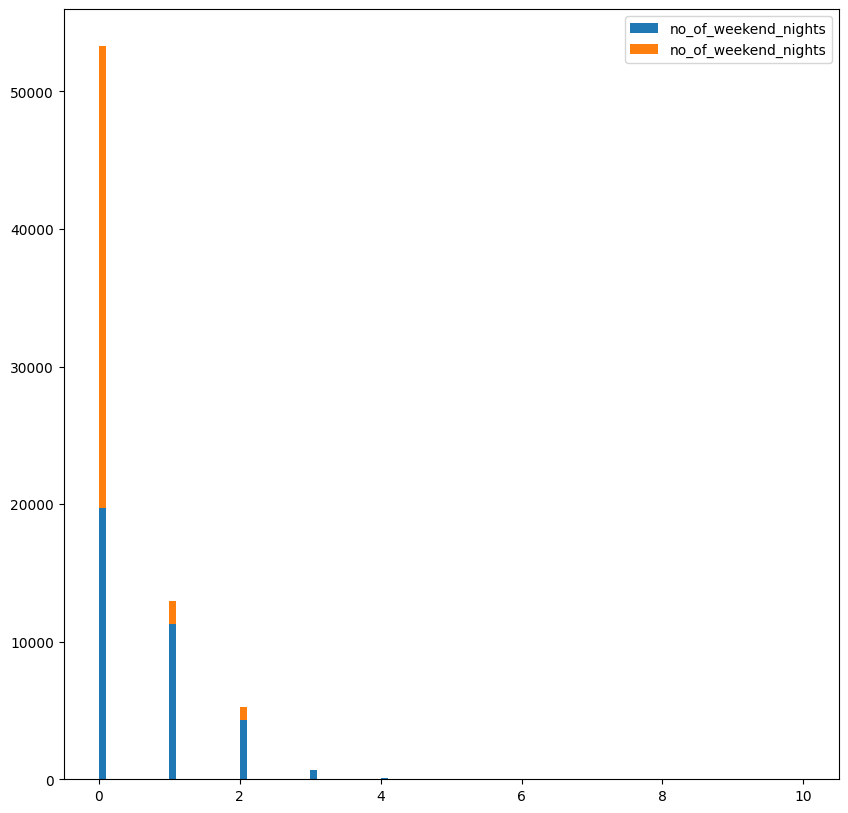

In [10]:
plt.figure(figsize=(10, 10))
plt.hist([hotel["avg_price_per_room"], hotel["lead_time"]], bins = 100, stacked=True, label = [col1, col2])
plt.legend()
plt.show()

plt.figure(figsize=(10, 10))
plt.hist([hotel["no_of_special_requests"], hotel["no_of_children"]], bins = 100, stacked=True, label = [col1, col2])
plt.legend()
plt.show()


### Boxplots conditionate

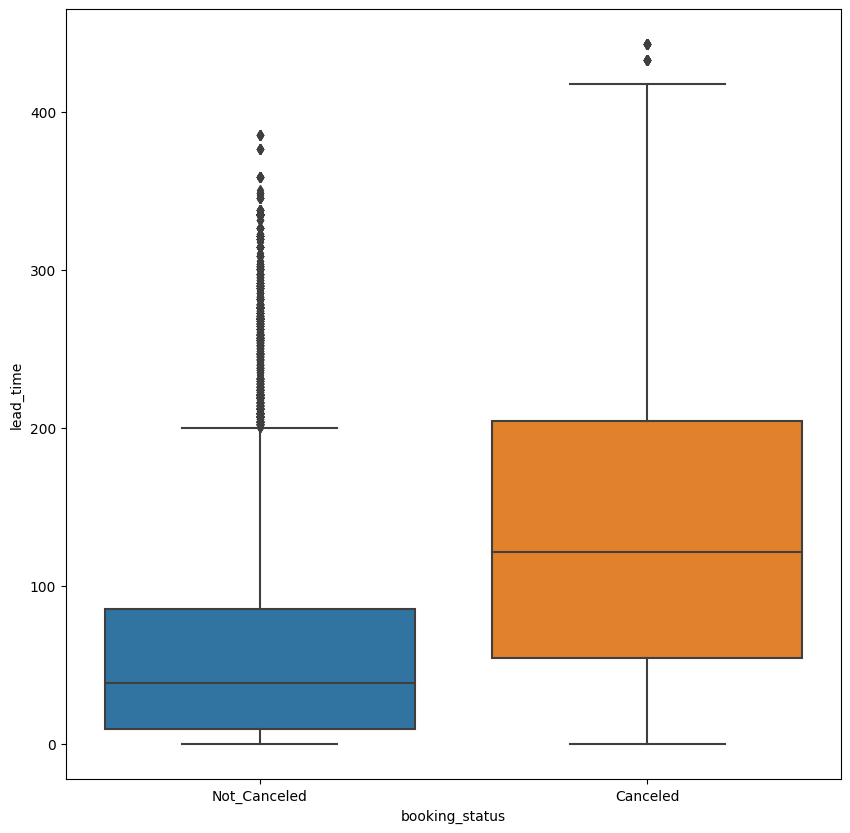

76.0
Outliers :  1035
150.0
Outliers :  42


In [71]:
#conditioned boxplot
plt.figure(figsize=(10, 10))
sns.boxplot(x="booking_status", y="lead_time", data=hotel)
plt.show()

#determine the number of outliers
Q1 = hotel[hotel.booking_status == 'Not_Canceled']["lead_time"].quantile(0.25)
Q3 = hotel[hotel.booking_status == 'Not_Canceled']["lead_time"].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

count = hotel[hotel.booking_status == 'Not_Canceled']["lead_time"][hotel.lead_time > Q3 + 1.5*IQR].count() +\
        hotel[hotel.booking_status == 'Not_Canceled']["lead_time"][hotel.lead_time < Q1 - 1.5*IQR].count()
print("Outliers : ", count)

#determine the number of outliers
# for entry in hotel[hotel.booking_status == 0]["lead_time"]:
#     if entry > Q3 + 1.5*IQR or entry < Q1 - 1.5*IQR:
        

Q1 = hotel[hotel.booking_status == 'Canceled']['lead_time'].quantile(0.25)
Q3 = hotel[hotel.booking_status == 'Canceled']['lead_time'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

count = hotel[hotel.booking_status == 'Canceled']["lead_time"][hotel.lead_time > Q3 + 1.5*IQR].count() +\
        hotel[hotel.booking_status == 'Canceled']["lead_time"][hotel.lead_time < Q1 - 1.5*IQR].count()

print("Outliers : ", count)



### Market segment type

In [152]:
pd.crosstab(hotel.market_segment_type, hotel.booking_status)

booking_status,Canceled,Not_Canceled
market_segment_type,,
Aviation,37,88
Complementary,0,391
Corporate,220,1797
Offline,3153,7375
Online,8475,14739


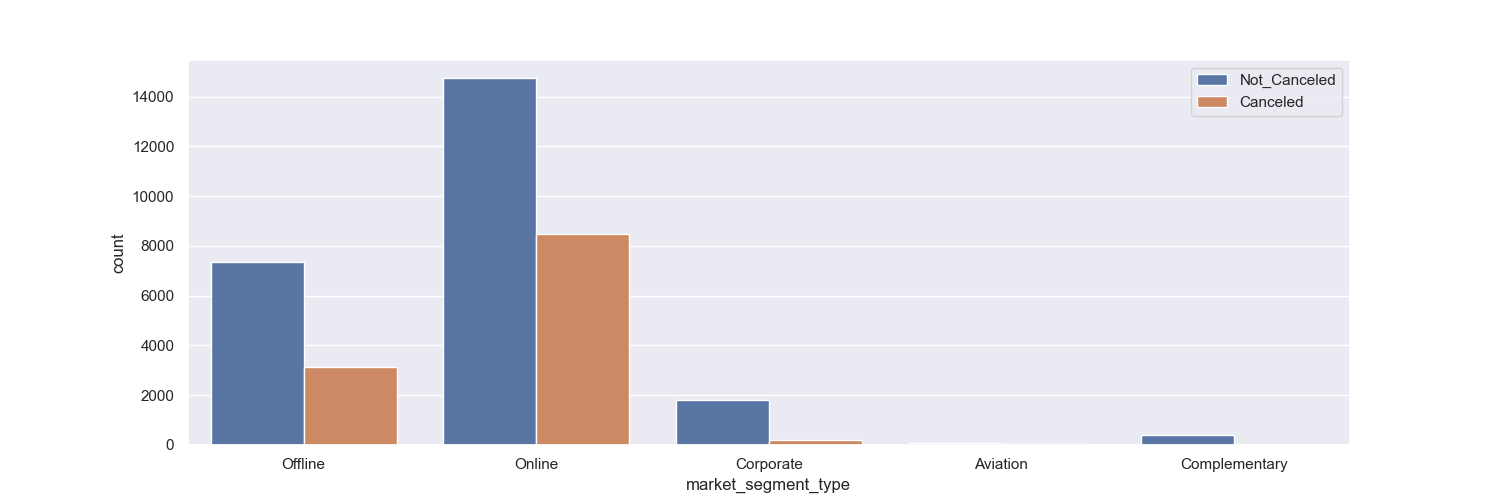

In [154]:
plt.figure(figsize=[15,5])
sns.set()
sns.countplot(x = 'market_segment_type', hue = 'booking_status', data = hotel)
plt.legend(loc = 1)

Putem observa cum se distribuie rezervarile in functie de tipul de pachet :
- rezervarile facute online au cea mai mare rata de anulare : 37.5, probabil din cauza ca anularea este mult mai usoara
- rezervarile corporate si complementary au cea mai mica rata de anulare: 10.9% si respectiv 0%
- rezervarile din aviation au o rata de anulare de 29%, ce poate fi datorata evenimentelor neprevazute

In [156]:
hotel.groupby('arrival_month')['booking_status'].value_counts(normalize = True)  

arrival_month  booking_status
1              Not_Canceled      0.976331
               Canceled          0.023669
2              Not_Canceled      0.747653
               Canceled          0.252347
3              Not_Canceled      0.703138
               Canceled          0.296862
4              Not_Canceled      0.636330
               Canceled          0.363670
5              Not_Canceled      0.635104
               Canceled          0.364896
6              Not_Canceled      0.596940
               Canceled          0.403060
7              Not_Canceled      0.550000
               Canceled          0.450000
8              Not_Canceled      0.609756
               Canceled          0.390244
9              Not_Canceled      0.666450
               Canceled          0.333550
10             Not_Canceled      0.646417
               Canceled          0.353583
11             Not_Canceled      0.706376
               Canceled          0.293624
12             Not_Canceled      0.866931
    

Observam ca lunile cu cea mai mare rata de anulare sunt iunie, iulie si august, cu iulie avand cea mai mare rata de anulare : 45%

In [ ]:
#conditioned boxplot
plt.figure(figsize=(10, 10))
sns.boxplot(x="booking_status", y="avg_price_per_room", data=hotel)
plt.show()

#determine the number of outliers
Q0 = hotel[hotel.booking_status == 'Not_Canceled']["avg_price_per_room"].quantile(0.0)
Q1 = hotel[hotel.booking_status == 'Not_Canceled']["avg_price_per_room"].quantile(0.25)
Q3 = hotel[hotel.booking_status == 'Not_Canceled']["avg_price_per_room"].quantile(0.75)
Q4 = hotel[hotel.booking_status == 'Not_Canceled']["avg_price_per_room"].quantile(1.0)
IQR = Q3 - Q1
print("Q0", Q0)
print("Q4", Q4)
print(IQR)

count = hotel[hotel.booking_status == 'Not_Canceled']["avg_price_per_room"][hotel.avg_price_per_room > Q3 + 1.5*IQR].count() +\
        hotel[hotel.booking_status == 'Not_Canceled']["avg_price_per_room"][hotel.avg_price_per_room < Q1 - 1.5*IQR].count()
print("Outliers : ", count)

#determine the number of outliers
# for entry in hotel[hotel.booking_status == 0]["avg_price_per_room"]:
#     if entry > Q3 + 1.5*IQR or entry < Q1 - 1.5*IQR:
        
Q0 = hotel[hotel.booking_status == 'Canceled']["avg_price_per_room"].quantile(0.0)
Q1 = hotel[hotel.booking_status == 'Canceled']['avg_price_per_room'].quantile(0.25)
Q3 = hotel[hotel.booking_status == 'Canceled']['avg_price_per_room'].quantile(0.75)
Q4 = hotel[hotel.booking_status == 'Canceled']["avg_price_per_room"].quantile(1.0)
IQR = Q3 - Q1
print("Q0", Q0)
print("Q4", Q4)
print(IQR)

count = hotel[hotel.booking_status == 'Canceled']["avg_price_per_room"][hotel.avg_price_per_room > Q3 + 1.5*IQR].count() +\
        hotel[hotel.booking_status == 'Canceled']["avg_price_per_room"][hotel.avg_price_per_room < Q1 - 1.5*IQR].count()

print("Outliers : ", count)

